## Library Import

In [120]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

## Part 1: Preparing the Dataset
### Task: Select 3 classes randomly from CIFAR-10 with 100 images per class.

In [121]:
#  data transformation to convert images to tensors
transform = transforms.ToTensor()

# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

np.random.seed(42)
torch.manual_seed(42)

# CIFAR-10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Randomly select 3 classes from the 10 available classes
selected_classes = np.random.choice(range(10), 3, replace=False)
selected_class_names = [class_names[i] for i in selected_classes]

# Print selected classes
print("Selected classes:")
for label, name in zip(selected_classes, selected_class_names):
    print(f" - Label {label}: {name}")

# Collect exactly 100 images for each selected class
subset_indices = []
for class_label in selected_classes:
    # Find all indices for the current class
    class_indices = [i for i, (_, label) in enumerate(dataset) if label == class_label]
    # Take only the first 100 images for this class
    subset_indices.extend(class_indices[:100])

# Create Subset and split into training (240), validation (45), and test sets (15)
subset = Subset(dataset, subset_indices)
train_size, val_size, test_size = 240, 45, 15
train_subset, val_subset, test_subset = random_split(subset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=5, shuffle=False)

# Checking subset sizes
print(f"Total images in training set: {len(train_subset)}")   # Should be 240
print(f"Total images in validation set: {len(val_subset)}")   # Should be 45
print(f"Total images in test set: {len(test_subset)}")        # Should be 15


Files already downloaded and verified
Selected classes:
 - Label 8: Ship
 - Label 1: Automobile
 - Label 5: Dog
Total images in training set: 240
Total images in validation set: 45
Total images in test set: 15


Now we have randomly selected the classess and 100 images from each class ,lets move onto building and training the autoencoder part

## Part 2: Building the Autoencoder Model
### Task: Build an autoencoder with CNN layers, where the bottleneck has only 2 units for 2D embedding.

The <b> CNN autoencoder </b> will:
<br> - Use <b> Convolutional </b> layers in the encoder to capture spatial features.
<br> - Compress the features into a 2D representation in the <b>bottleneck layer</b>.
<br> - Use <b>Transpose convolutions</b> in the decoder to reconstruct the images.

In [122]:
class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        
        # Encoder: Using stride=2 in convolutional layers to reduce spatial dimensions
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # (32x32x3) -> (16x16x32)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (16x16x32) -> (8x8x64)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (8x8x64) -> (4x4x128)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4 * 4 * 128, 2)  # Bottleneck layer with 2 units
        )
        
        # Decoder: Using transposed convolutions to upsample back to original dimensions
        self.decoder = nn.Sequential(
            nn.Linear(2, 4 * 4 * 128),                      # Expand back to flattened 4x4x128
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (4x4x128) -> (8x8x64)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # (8x8x64) -> (16x16x32)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),    # (16x16x32) -> (32x32x3)
            nn.Sigmoid()  # Output values in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Part 3: Training the Autoencoder
### Task: Train the autoencoder on  CIFAR-10 subset, with MSE loss and an appropriate optimizer.
This training process will use Mean Squared Error (MSE) as the loss function, a standard choice for image reconstruction tasks.


In [123]:
# Initialize model, loss function, and optimizer
model = CNN_Autoencoder()
criterion = nn.MSELoss()  # Reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
for epoch in range(epochs):
    train_loss = 0
    for images, _ in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)  # Compare output to input for reconstruction
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}")


Epoch [1/20], Loss: 0.0676
Epoch [2/20], Loss: 0.0608
Epoch [3/20], Loss: 0.0582
Epoch [4/20], Loss: 0.0544
Epoch [5/20], Loss: 0.0478
Epoch [6/20], Loss: 0.0452
Epoch [7/20], Loss: 0.0446
Epoch [8/20], Loss: 0.0440
Epoch [9/20], Loss: 0.0436
Epoch [10/20], Loss: 0.0437
Epoch [11/20], Loss: 0.0431
Epoch [12/20], Loss: 0.0429
Epoch [13/20], Loss: 0.0426
Epoch [14/20], Loss: 0.0425
Epoch [15/20], Loss: 0.0423
Epoch [16/20], Loss: 0.0425
Epoch [17/20], Loss: 0.0421
Epoch [18/20], Loss: 0.0421
Epoch [19/20], Loss: 0.0422
Epoch [20/20], Loss: 0.0421


## Part 4: Visualizing the 2D Embeddings
### Task: Obtain the 2D embeddings of all images and plot them, using different symbols for each class.


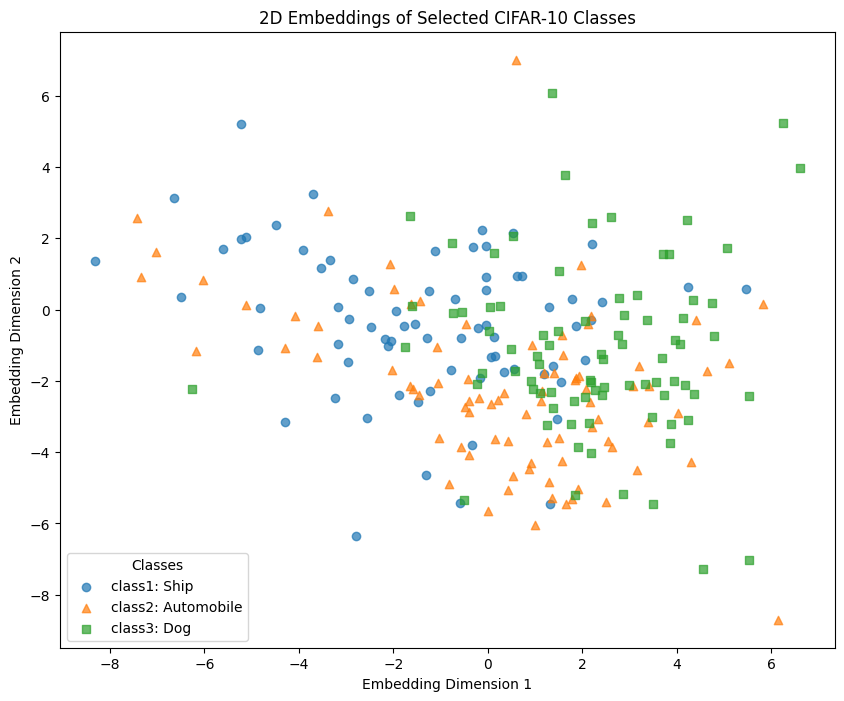

In [124]:

# Set model to evaluation mode
model.eval()

# Define markers for each training class
class_markers = ['o', '^', 's']
class_names = [f"class{i+1}: {name}" for i, name in enumerate(selected_class_names)]
selected_classes = selected_classes.tolist()

# Get embeddings for training images
embeddings = []
labels = []
with torch.no_grad():
    for images, lbls in train_loader:
        encoded = model.encoder(images.to('cpu')).to('cpu')
        embeddings.append(encoded.numpy())
        labels.extend(lbls.numpy())

embeddings = np.concatenate(embeddings)
labels = np.array(labels)

# Plot each class with a unique marker
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(selected_classes):
    indices = np.where(labels == class_label)
    plt.scatter(
        embeddings[indices][:, 0],
        embeddings[indices][:, 1],
        marker=class_markers[i], 
        label=class_names[i], 
        alpha=0.7
    )

# labels and title
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("2D Embeddings of Selected CIFAR-10 Classes")
plt.legend(title="Classes")
plt.show()


## Part 5: Testing with New Images
### Task: Select 5 new images, obtain their embeddings, and observe where they fall in the 2D space.

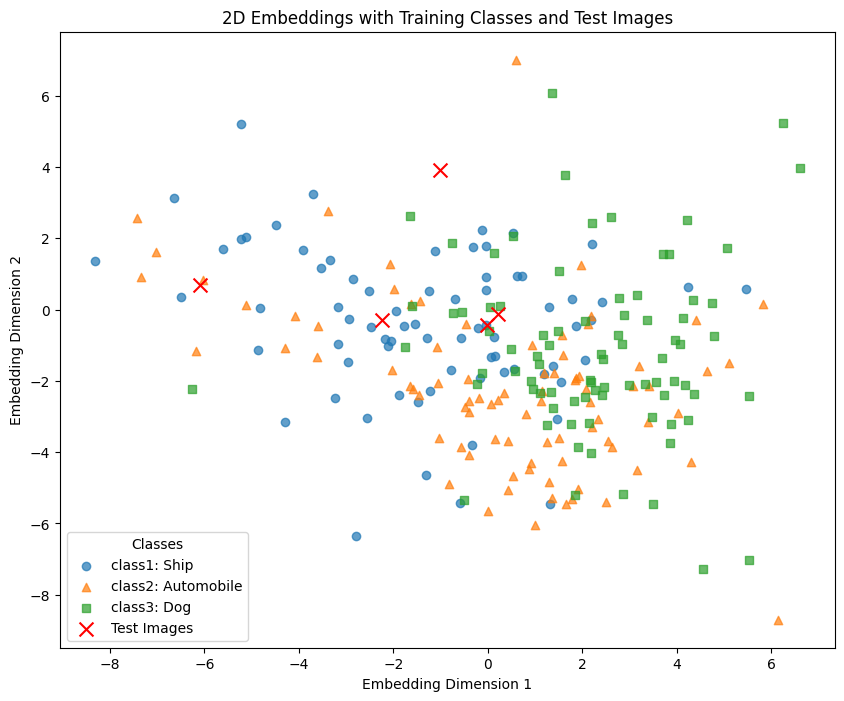

In [125]:
model.eval()

# Define markers for each class in the training set
class_markers = ['o', '^', 's']  # Example markers: Circle, Triangle, Square
class_names = [f"class{i+1}: {name}" for i, name in enumerate(selected_class_names)]

# Plot the 2D embeddings of the training data (from task 3)
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(selected_classes):
    indices = np.where(labels == class_label)
    plt.scatter(
        embeddings[indices][:, 0],
        embeddings[indices][:, 1],
        marker=class_markers[i], 
        label=class_names[i], 
        alpha=0.7
    )

# Select exactly 5 random images from the test set (images not used for training)
test_embeddings = []
test_labels = []

# Initialize a list to hold exactly 5 random images from the test set
random_test_indices = np.random.choice(len(test_subset), 5, replace=False)

# Get embeddings for these 5 randomly selected test images
with torch.no_grad():
    for i in random_test_indices:
        image, label = test_subset[i]  # Fetch the image and label
        image = image.unsqueeze(0)  # Add batch dimension
        encoded = model.encoder(image.to('cpu')).to('cpu')  # Get 2D embedding
        test_embeddings.append(encoded.numpy())
        test_labels.append(label)

# Convert embeddings and labels to numpy arrays for easy plotting
test_embeddings = np.vstack(test_embeddings)
test_labels = np.array(test_labels)

# Plot the 5 test images on the same plot with a distinct marker/color
plt.scatter(
    test_embeddings[:, 0], 
    test_embeddings[:, 1], 
    marker='x', 
    color='red', 
    s=100, 
    label="Test Images"
)

# Finalize the plot
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("2D Embeddings with Training Classes and Test Images")
plt.legend(title="Classes")
plt.show()


The test images (red "X"s) are positioned near clusters of the training classes, indicating that the model successfully embedded them close to similar images in the learned 2D space. This alignment shows that the model generalizes well, placing new images in relevant areas based on class similarity.

## Task: Supervised Autoencoder


Here’s how we’ll structure it:

This model will:
<br> - Include an encoder, a decoder, and a classifier head.
<br> - Use a combined loss: MSELoss for reconstruction and CrossEntropyLoss for classification.

### DATA PREPROCESSING

In [126]:

# Define data transformation to convert images to tensors
transform = transforms.ToTensor()
np.random.seed(42)
torch.manual_seed(42)
# Load CIFAR-10 dataset
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)

# CIFAR-10 class names
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Randomly select 3 classes from the 10 available classes
selected_classes = np.random.choice(range(10), 3, replace=False)
selected_class_names = [class_names[i] for i in selected_classes]

# Print selected classes
print("Selected classes:")
for label, name in zip(selected_classes, selected_class_names):
    print(f" - Label {label}: {name}")

# Collect exactly 100 images for each selected class
subset_indices = []
for class_label in selected_classes:
    class_indices = [i for i, (_, label) in enumerate(dataset) if label == class_label]
    subset_indices.extend(class_indices[:100])

# Create Subset and split into training (240), validation (45), and test sets (15)
subset = Subset(dataset, subset_indices)
train_size, val_size, test_size = 240, 45, 15
train_subset, val_subset, test_subset = random_split(subset, [train_size, val_size, test_size])

# Map selected class labels to a continuous range [0, 2]
label_mapping = {selected_classes[i]: i for i in range(3)}

# Custom dataset to apply the label mapping
class MappedSubset(Dataset):
    def __init__(self, subset, label_mapping):
        self.subset = subset
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        image, label = self.subset[idx]
        mapped_label = self.label_mapping[label]
        return image, mapped_label

# Apply the mapping to the subsets
train_mapped_subset = MappedSubset(train_subset, label_mapping)
val_mapped_subset = MappedSubset(val_subset, label_mapping)
test_mapped_subset = MappedSubset(test_subset, label_mapping)

# Create DataLoaders for each set
train_loader = DataLoader(train_mapped_subset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_mapped_subset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_mapped_subset, batch_size=5, shuffle=False)


Files already downloaded and verified
Selected classes:
 - Label 8: Ship
 - Label 1: Automobile
 - Label 5: Dog


### Supervised Autoencoder


In [127]:
import torch
import torch.nn as nn

# Supervised Autoencoder Model with MaxPooling
class SupervisedAutoencoder(nn.Module):
    def __init__(self):
        super(SupervisedAutoencoder, self).__init__()
        
        # Encoder with MaxPooling layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (32x32x3) -> (32x32x32)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (32x32x32) -> (16x16x32)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # (16x16x32) -> (16x16x64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (16x16x64) -> (8x8x64)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# (8x8x64) -> (8x8x128)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # (8x8x128) -> (4x4x128)
            
            nn.Flatten(),
            nn.Linear(4 * 4 * 128, 2)                    # Bottleneck layer with 2 units
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 4 * 4 * 128),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        # Classification Head for Supervised Learning
        self.classifier = nn.Linear(2, 3)  # 3 output classes for the selected CIFAR-10 classes

    def forward(self, x):
        # Encoding (feature extraction)
        z = self.encoder(x)
        
        # Decoding (reconstruction)
        reconstructed = self.decoder(z)
        
        # Classification head for supervised learning
        class_output = self.classifier(z)
        
        return reconstructed, class_output, z


### Training Loop with Combined Loss

In [128]:
# Initialize model, loss functions, and optimizer
model = SupervisedAutoencoder()
reconstruction_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 20
for epoch in range(epochs):
    train_loss = 0
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed_images, class_outputs, _ = model(images)
        
        # Calculate losses
        reconstruction_loss = reconstruction_criterion(reconstructed_images, images)
        classification_loss = classification_criterion(class_outputs, labels)
        loss = reconstruction_loss + classification_loss  # Combined loss
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}")

Epoch [1/20], Loss: 1.2188
Epoch [2/20], Loss: 1.0640
Epoch [3/20], Loss: 1.0140
Epoch [4/20], Loss: 0.9471
Epoch [5/20], Loss: 0.9040
Epoch [6/20], Loss: 0.8512
Epoch [7/20], Loss: 0.8381
Epoch [8/20], Loss: 0.7706
Epoch [9/20], Loss: 0.7034
Epoch [10/20], Loss: 0.6241
Epoch [11/20], Loss: 0.5054
Epoch [12/20], Loss: 0.4796
Epoch [13/20], Loss: 0.4120
Epoch [14/20], Loss: 0.3718
Epoch [15/20], Loss: 0.3453
Epoch [16/20], Loss: 0.4322
Epoch [17/20], Loss: 0.4587
Epoch [18/20], Loss: 0.3516
Epoch [19/20], Loss: 0.2731
Epoch [20/20], Loss: 0.2259


### Visualize the 2D Embeddings

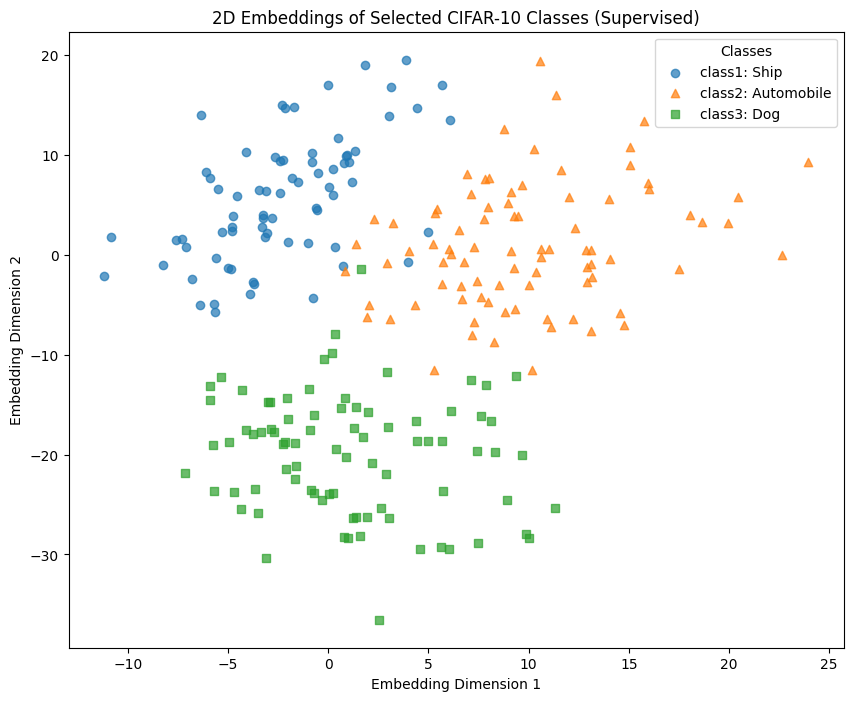

In [129]:
# Visualize the 2D embeddings for each class
model.eval()
embeddings = []
labels = []
with torch.no_grad():
    for images, lbls in train_loader:
        _, _, z = model(images)
        embeddings.append(z.numpy())
        labels.extend(lbls.numpy())

# Convert embeddings and labels to numpy arrays
embeddings = np.concatenate(embeddings)
labels = np.array(labels)

# Plot the 2D embeddings
class_markers = ['o', '^', 's']
class_names = [f"class{i+1}: {name}" for i, name in enumerate(selected_class_names)]
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(selected_classes):
    indices = np.where(labels == i)  # Note: labels are now [0, 1, 2]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        marker=class_markers[i], 
        label=class_names[i], 
        alpha=0.7
    )

# Add labels and title
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.title("2D Embeddings of Selected CIFAR-10 Classes (Supervised)")
plt.legend(title="Classes")
plt.show()
